In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
import scipy
import os
import cv2

In [2]:
data = pd.read_csv('./data/fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:
data.shape

(35887, 3)

In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

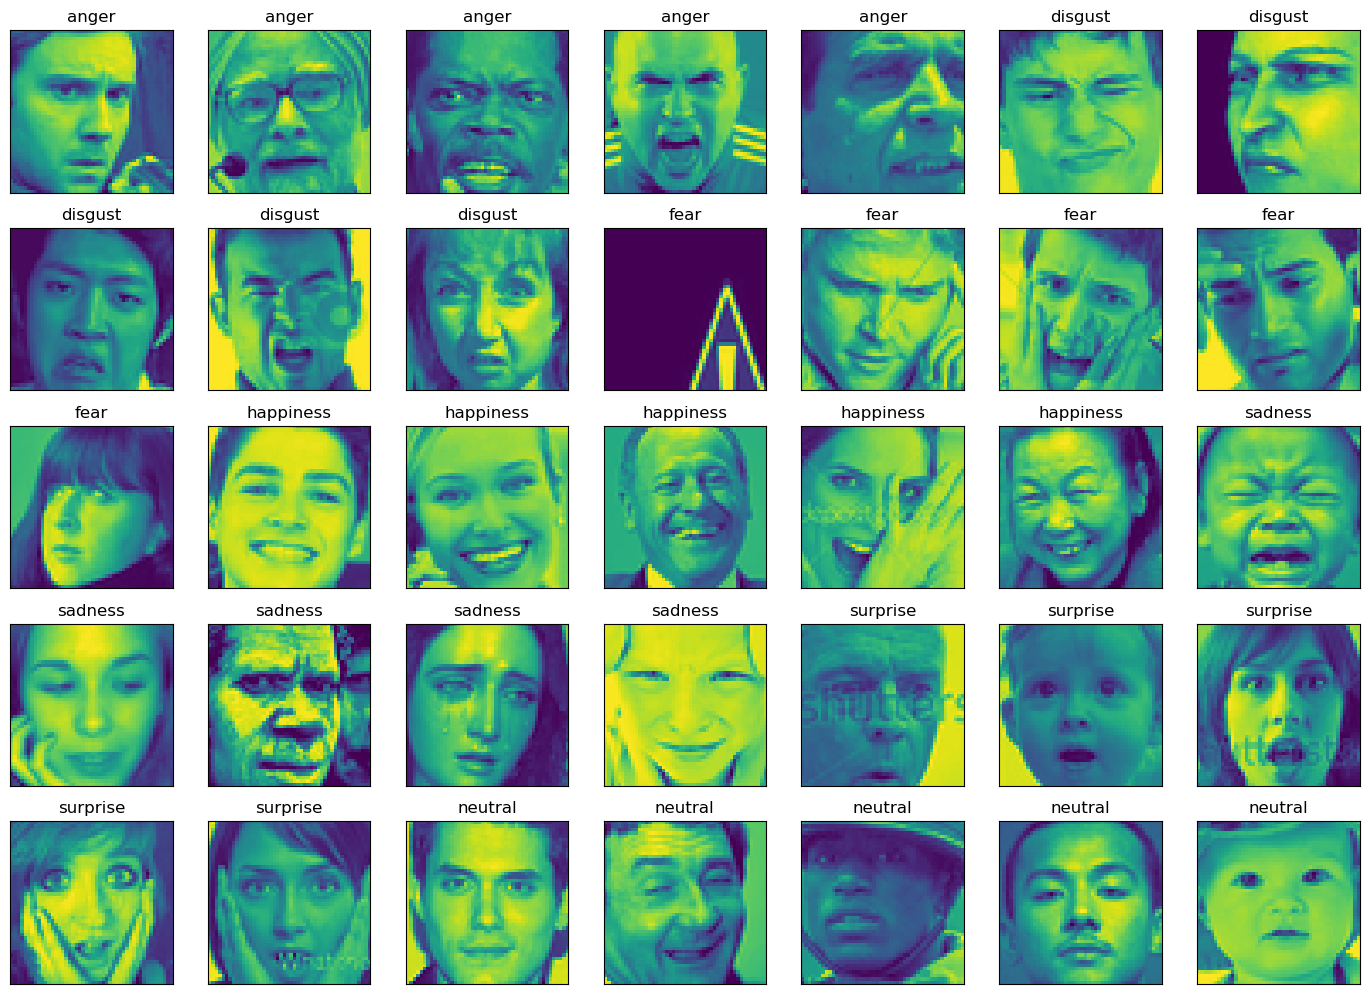

In [5]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [6]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

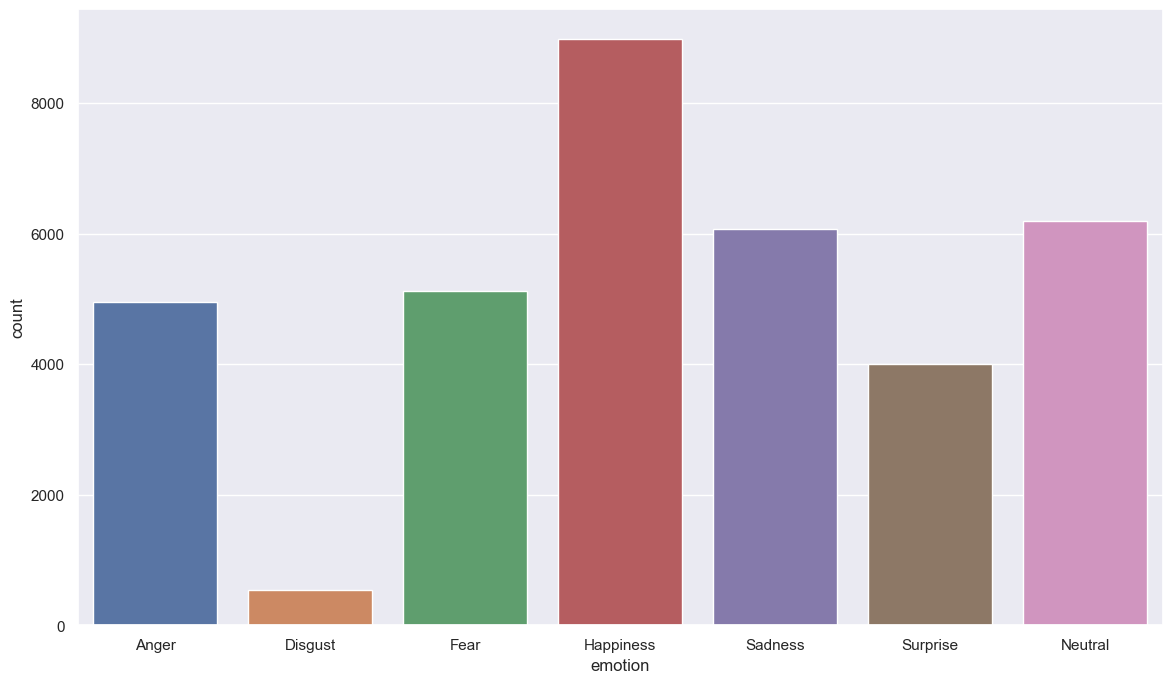

In [7]:
emotion_labels = [ 'Anger','Disgust','Fear', 'Happiness', 'Sadness', 'Surprise','Neutral']

plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)
ax.set_xticklabels(emotion_labels)  
plt.savefig('./imgs/fer2013.png')
plt.show()


In [8]:
x_data = data['pixels']
y_data = data['emotion']

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [10]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [11]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    28 55 81 91 103 70 32 16 51 100 110 140 161 17...
62919    120 121 123 120 120 122 127 67 55 86 89 92 96 ...
62920    143 142 145 169 193 174 147 139 143 155 168 18...
62921    116 120 84 21 27 30 34 39 46 49 50 51 53 56 56...
62922    90 83 82 87 82 78 108 173 175 174 170 170 170 ...
Length: 62923, dtype: object

In [12]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [13]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [14]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [16]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [ ]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(x_train)
batch_size = 64
train_flow = datagen.flow(x_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(x_test, y_test, batch_size=batch_size)


In [17]:
y_train = to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [18]:
y_test = to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [19]:
model = Sequential([
    
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    
    Flatten(),

    
    Dense(250, activation='relu'),
    Dropout(0.5),

    
    Dense(7, activation = 'softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                       

In [21]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


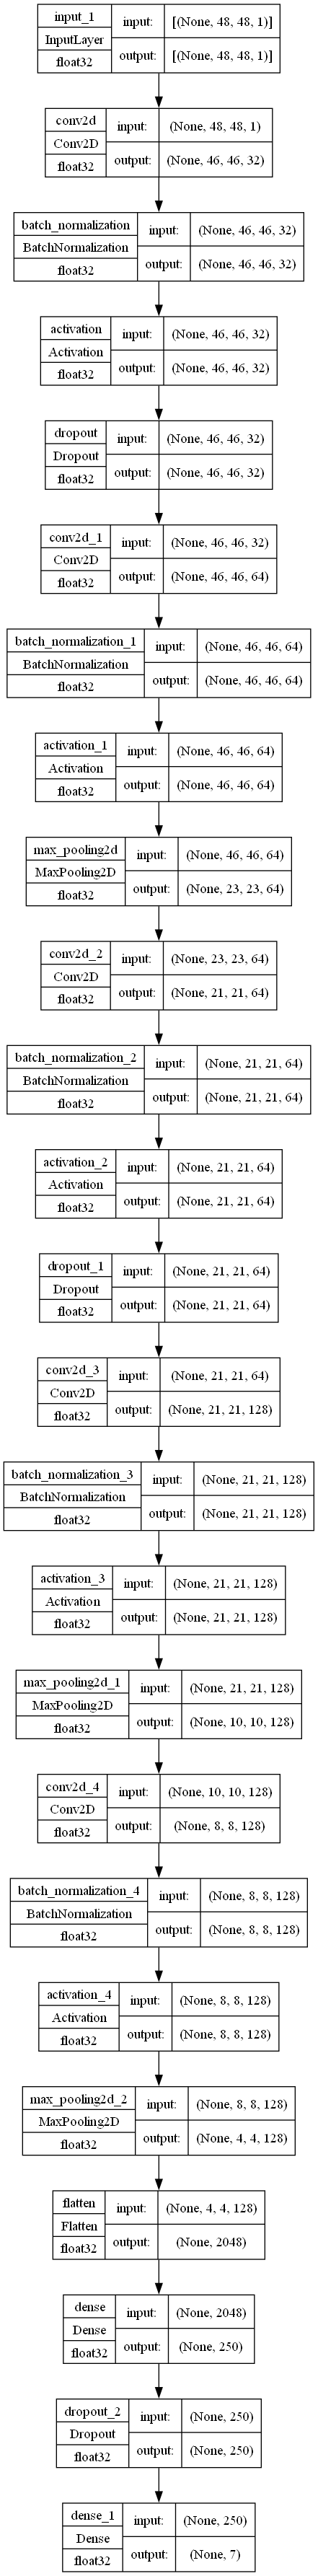

In [22]:
tf.keras.utils.plot_model(model, to_file = "./imgs/best_model.png", show_shapes = True, show_dtype = True)

In [23]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,   
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=len(X_test) / batch_size)


Epoch 1/35


1770/1770 [==============================] - 479s 267ms/step - loss: 1.8224 - accuracy: 0.2764 - val_loss: 1.6729 - val_accuracy: 0.3436
Epoch 2/35
1770/1770 [==============================] - 392s 221ms/step - loss: 1.5592 - accuracy: 0.4027 - val_loss: 1.4153 - val_accuracy: 0.4704
Epoch 3/35
1770/1770 [==============================] - 392s 221ms/step - loss: 1.3875 - accuracy: 0.4734 - val_loss: 1.2649 - val_accuracy: 0.5160
Epoch 4/35
1770/1770 [==============================] - 418s 236ms/step - loss: 1.2682 - accuracy: 0.5202 - val_loss: 1.1361 - val_accuracy: 0.5670
Epoch 5/35
1770/1770 [==============================] - 391s 221ms/step - loss: 1.1814 - accuracy: 0.5532 - val_loss: 1.0618 - val_accuracy: 0.5997
Epoch 6/35
1770/1770 [==============================] - 392s 221ms/step - loss: 1.1063 - accuracy: 0.5817 - val_loss: 1.0241 - val_accuracy: 0.6059
Epoch 7/35
1770/1770 [==============================] - 392s 221ms/step - loss: 1.0497 - accuracy: 0.6044 - va

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

197/197 [==============================] - 7s 35ms/step - loss: 0.5890 - accuracy: 0.8171
Accuracy of our model on test data :  81.70983791351318 %
197/197 [==============================] - 7s 36ms/step - loss: 0.5890 - accuracy: 0.8171
Loss of our model on test data :  0.5890301465988159


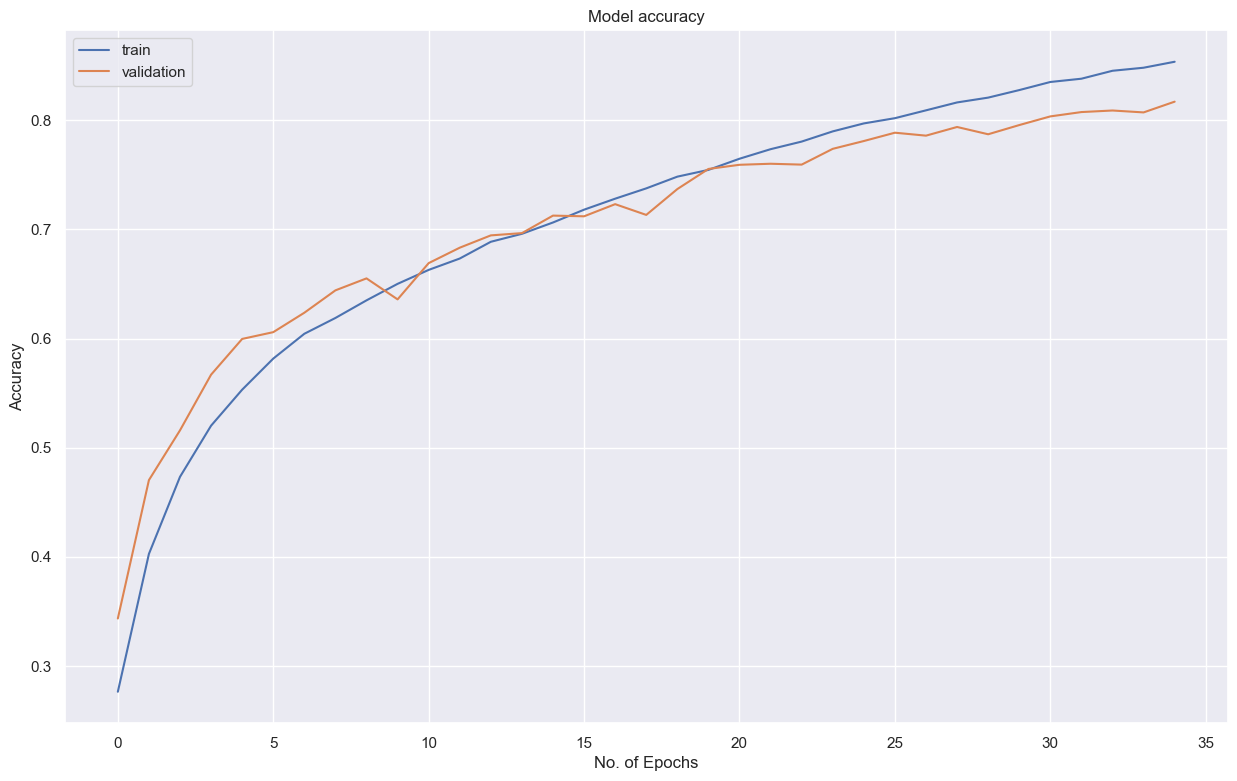

In [42]:
plt.figure(figsize=(15, 9))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('./imgs/accuracy.png')
plt.show()

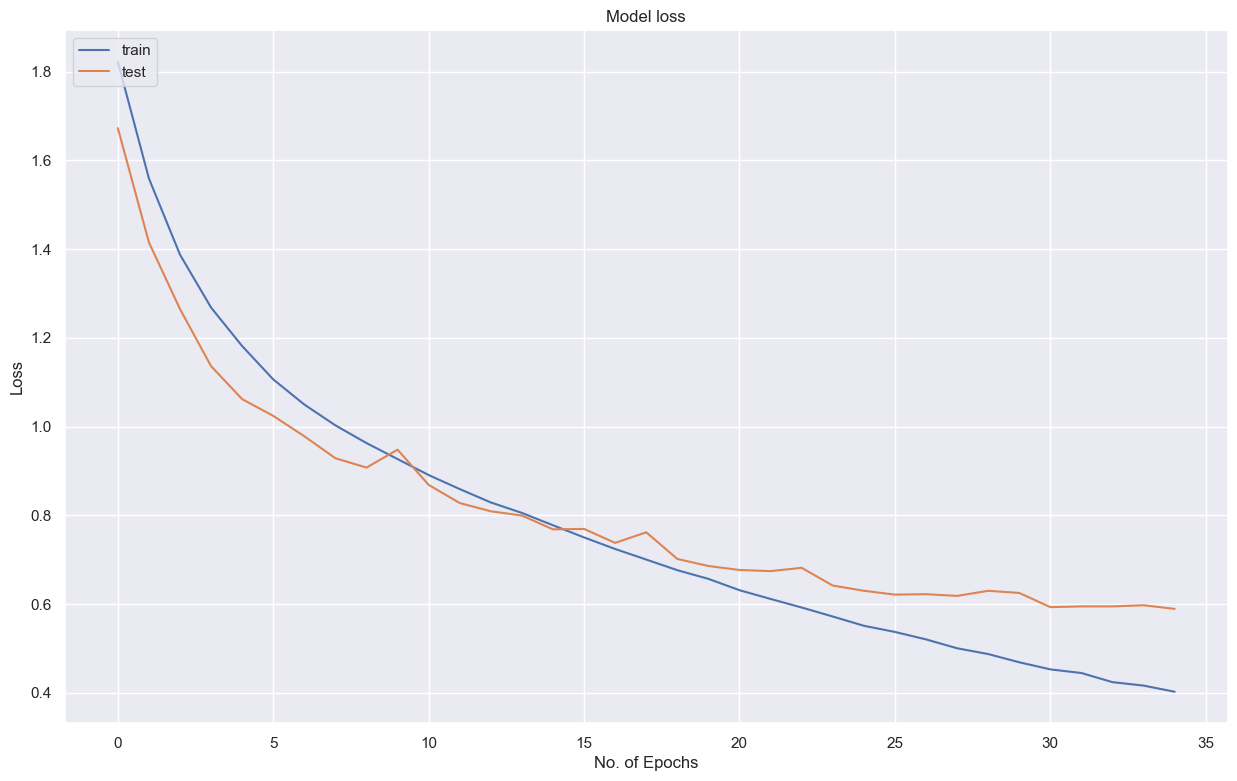

In [30]:
plt.figure(figsize=(15, 9))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./imgs/loss.png')
plt.show()

In [19]:
from tensorflow.keras.models import load_model, model_from_json
model = model_from_json(open("Facial Expression Recognition.json", "r").read())
model.load_weights('fer.h5')

y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))




197/197 [==============================] - 6s 27ms/step


In [20]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
emotional_labels = [ 'Anger','Disgust','Fear', 'Happiness', 'Sadness', 'Surprise','Neutral']
print(classification_report(y_actual, y_result,target_names=emotional_labels))

              precision    recall  f1-score   support

       Anger       0.83      0.78      0.80       935
     Disgust       0.98      1.00      0.99       895
        Fear       0.79      0.70      0.74       880
   Happiness       0.85      0.81      0.83       906
     Sadness       0.72      0.67      0.70       888
    Surprise       0.88      0.97      0.92       869
     Neutral       0.68      0.80      0.73       920

    accuracy                           0.82      6293
   macro avg       0.82      0.82      0.82      6293
weighted avg       0.82      0.82      0.82      6293



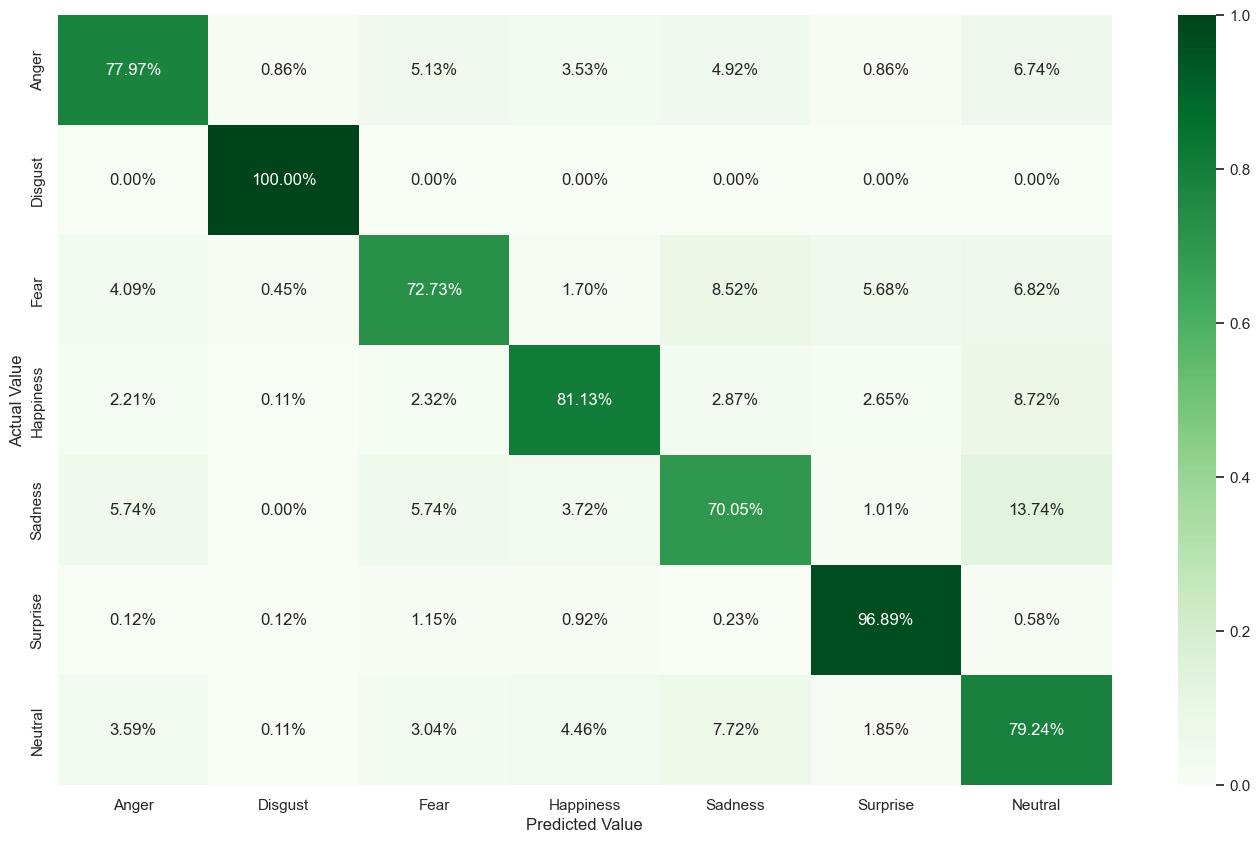

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


cm = tf.math.confusion_matrix(labels=y_actual, predictions=y_result)


cm_percent = cm / np.sum(cm, axis=1, keepdims=True)


emotional_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plt.figure(figsize=(17, 10))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap="Greens", 
            xticklabels=emotional_labels, yticklabels=emotional_labels)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.savefig('./imgs/confusion_matrix.png')
plt.show()


In [40]:
model.save("./Facial_Expression_Detection_System.hdf5")

C:\Users\Acer\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
fer_json = model.to_json()
with open("./Facial Expression Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

In [52]:
print("Shape of y_actual", y_actual.shape)
print("Shape of y_result:", y_result.shape)


Shape of y_actual (6293,)
Shape of y_result: (6293, 7)


197/197 [==============================] - 4s 22ms/step


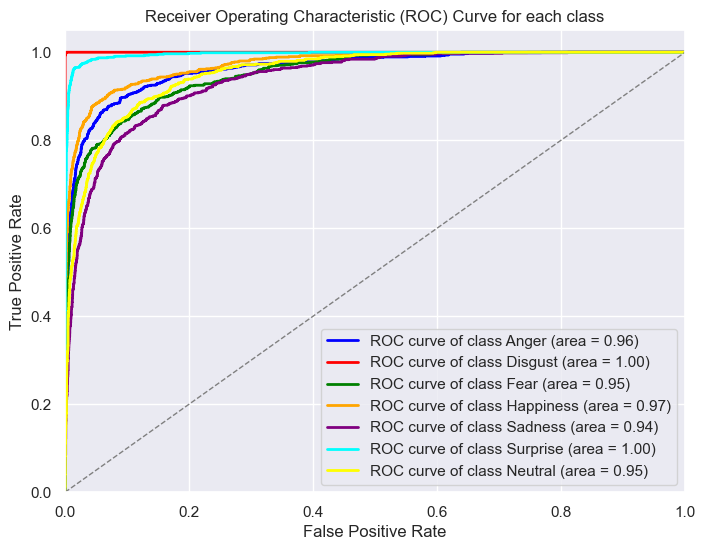

In [22]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = [ 'Anger','Disgust','Fear', 'Happiness', 'Sadness', 'Surprise','Neutral']
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple','aqua','yellow']  
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc="lower right")

plt.savefig('./imgs/ROC.png')
plt.show()






1/1 [==============================] - 0s 19ms/step


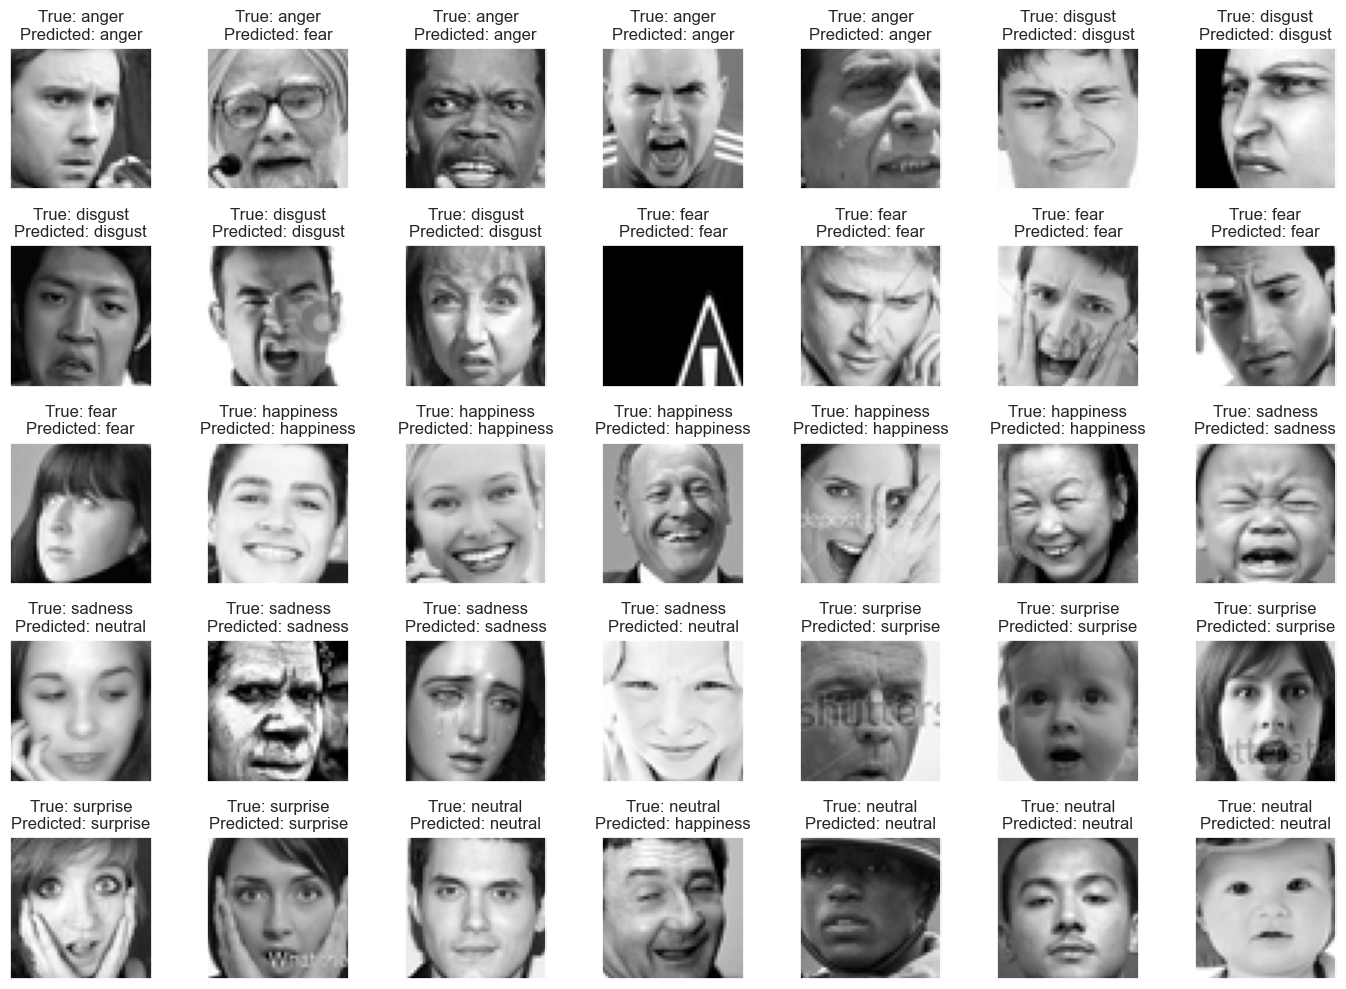

In [30]:
from tensorflow.keras.models import load_model, model_from_json
import matplotlib.pyplot as plt
import numpy as np

# Assuming data and label_to_text are defined somewhere in your code

# Function for image preprocessing
def preprocess_image(px):
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    # Convert to grayscale
    px = np.expand_dims(px, axis=-1)
    # Normalize by dividing by 255
    px /= 255.0
    return px

model = model_from_json(open("Facial Expression Recognition.json", "r").read())
model.load_weights('fer.h5')

fig = plt.figure(1, (14, 14))
k = 0

for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        preprocessed_img = preprocess_image(px)

        # Make predictions using your model
        img = np.expand_dims(preprocessed_img, axis=0)
        prediction = model.predict(img)
        predicted_label = np.argmax(prediction)

        ax = plt.subplot(7, 7, k+1)
        ax.imshow(preprocessed_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {label_to_text[label]}\nPredicted: {label_to_text[predicted_label]}')
        plt.tight_layout()

        k += 1

plt.show()
